<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/analysis/analysis_userdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## User Data Store の分析
- 2023-04-04 時点のdynamodbをexport

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
!pip install -q awscli
!pip install -U kaleido
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=182a202ad366b87c4d4f004ac0027992cd3a2e10a25a5afabdcd76df8cbf7c3d
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [74]:
import os
import gzip
import shutil
import glob
import json
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import japanize_matplotlib 

In [4]:
config_path = "/content/drive/MyDrive/z-gard/aws_config/awscli.ini"
!export AWS_SHARED_CREDENTIALS_FILE=$config_path
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = config_path
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

/content/drive/MyDrive/z-gard/aws_config/awscli.ini


In [5]:
DIR_NAME = '/content/drive/MyDrive/z-gard/'

In [48]:
EXPORT_DATE = '20230612'
EXPORT_DIR = os.path.join(DIR_NAME, f'dynamodb_export/{EXPORT_DATE}')
os.makedirs(EXPORT_DIR, exist_ok=True)

In [49]:
source_s3 = 's3://tokyo-story-user-data/AWSDynamoDB/01686533613858-47c4e7a7/data/'

!aws s3 cp $source_s3 $EXPORT_DIR --recursive

download: s3://tokyo-story-user-data/AWSDynamoDB/01686533613858-47c4e7a7/data/gyygck3aoy4e7ekzln4n55pfhy.json.gz to drive/MyDrive/z-gard/dynamodb_export/20230612/gyygck3aoy4e7ekzln4n55pfhy.json.gz
download: s3://tokyo-story-user-data/AWSDynamoDB/01686533613858-47c4e7a7/data/3r67vsjfnq2czkljzgdodtkznu.json.gz to drive/MyDrive/z-gard/dynamodb_export/20230612/3r67vsjfnq2czkljzgdodtkznu.json.gz
download: s3://tokyo-story-user-data/AWSDynamoDB/01686533613858-47c4e7a7/data/5vqcxrsw3yyavcyjisu33bhhpe.json.gz to drive/MyDrive/z-gard/dynamodb_export/20230612/5vqcxrsw3yyavcyjisu33bhhpe.json.gz
download: s3://tokyo-story-user-data/AWSDynamoDB/01686533613858-47c4e7a7/data/hichhtvs3a3q3j4pxx7lw2xy7e.json.gz to drive/MyDrive/z-gard/dynamodb_export/20230612/hichhtvs3a3q3j4pxx7lw2xy7e.json.gz


In [50]:
gzfile_list = glob.glob(os.path.join(EXPORT_DIR, '*.json.gz'))
print(len(gzfile_list))

4


In [51]:
for gzfile in gzfile_list:
    target_file = os.path.join(EXPORT_DIR, os.path.basename(gzfile)[:-3])
    with gzip.open(gzfile, mode="rb") as gzip_file:
        with open(target_file, mode="wb") as decompressed_file:
            shutil.copyfileobj(gzip_file, decompressed_file)

In [52]:
json_list = glob.glob(os.path.join(EXPORT_DIR, '*.json'))
print(len(json_list))

4


In [53]:
json_file_read = []
for json_file in json_list:
    with open(json_file) as f:
        json_file_read += f.readlines()

print(len(json_file_read))

9554


In [54]:
db_contents = []
for line in json_file_read:
    db_contents.append(json.loads(line)['Item'])

In [55]:
df_db_contents = pd.DataFrame(db_contents)
print(df_db_contents.shape)

(9554, 5)


In [56]:
def get_contents(x):
    if x.get('S') is not None:
        return x['S']
    elif x.get('N') is not None:
        return float(x['N'])
    elif x.get('L') is not None:
        _list = list(x['L'])
        output = []
        for item in _list:
            output.append(get_contents(item))
        return output
    elif x.get('M') is not None:
        _dict = dict(x['M'])
        output = {}
        for k, v in _dict.items():
            output[k] = get_contents(v)
        return output
    else:
        return x

In [57]:
df_db_contents['user_id'] = df_db_contents['user_id'].apply(get_contents)
df_db_contents['datetime'] = pd.to_datetime(df_db_contents['datetime'].apply(get_contents), format='%Y-%m-%dT%H:%M:%S.%f%z')
df_db_contents['date'] = df_db_contents['datetime'].dt.date

In [58]:
df_db_contents['questions'] = df_db_contents['questions'].apply(get_contents)
df_db_contents['ranking'] = df_db_contents['ranking'].apply(get_contents).apply(lambda x: x.get('items'))
df_db_contents['details'] = df_db_contents['details'].apply(get_contents)

df_db_contents['questions_count'] = df_db_contents['questions'].apply(lambda x: len(x))
df_db_contents['ranking_count'] = df_db_contents['ranking'].apply(lambda x: 0 if x is None else len(x))
df_db_contents['details_count'] = df_db_contents['details'].apply(lambda x: len(x))

In [59]:
df_db_contents['question_cat'] = ''
df_db_contents.loc[df_db_contents['questions_count'] < 18, 'question_cat'] = '1~17'
df_db_contents.loc[df_db_contents['questions_count'] == 0, 'question_cat'] = '0'
df_db_contents.loc[df_db_contents['questions_count'] >= 18, 'question_cat'] = '18~23'

In [60]:
df_db_contents['details_cat'] = ''
df_db_contents.loc[df_db_contents['details_count'] <= 5, 'details_cat'] = df_db_contents['details_count'].astype(str)
df_db_contents.loc[df_db_contents['details_count'] > 5, 'details_cat'] = '> 5'

In [61]:
def get_answer(x, question):
    answer = x.get(question)
    if answer is None:
        return None
    else:
        return answer[0]

In [62]:
questions = ['family', 'my_age', 'number_of_children', 'child_age', 'annual_income']
for question in questions:
    df_db_contents[question] = df_db_contents['questions'].apply(lambda x: get_answer(x, question))

In [63]:
df_db_contents.head()

,user_id,ranking,datetime,questions,details,date,questions_count,ranking_count,details_count,question_cat,details_cat,family,my_age,number_of_children,child_age,annual_income
0,b4c2ead82f339c65bf33e6f78bf59b92,"[{'rank': 1.0, 'ward_name': '江東区', 'nearest_st...",2023-03-16 21:41:17.914438+09:00,"{'annual_income': ['800'], 'circumstance': ['商...","{'103031': {'copyright': '©港区役所', 'latitude': ...",2023-03-16,18,10,4,18~23,4,単身,10,None,None,800
1,54694569be7fbe57423c1960b79565c0,"[{'rank': 1.0, 'ward_name': '豊島区', 'nearest_st...",2023-03-11 02:48:32.433622+09:00,"{'annual_income': ['2000'], 'circumstance': ['...",{},2023-03-11,18,10,0,18~23,0,単身,50,None,None,2000
2,bf8b21be702fa7116adc02e760aec305,"[{'rank': 1.0, 'ward_name': '板橋区', 'nearest_st...",2023-03-25 13:04:50.395109+09:00,"{'annual_income': ['800'], 'circumstance': ['商...",{},2023-03-25,18,10,0,18~23,0,単身,20,None,None,800
3,19e761f485d0ab6940ee5f0822a0f37c,"[{'rank': 1.0, 'ward_name': '千代田区', 'nearest_s...",2023-03-10 08:27:12.877594+09:00,"{'annual_income': ['3000'], 'child_age': ['小学生...","{'106137': {'copyright': '©台東区(仮)', 'latitude'...",2023-03-10,22,10,1,18~23,1,夫婦子供,40,1,小学生,3000
4,68081e66544e1d0a50dc88b74c8b4ade,"[{'rank': 1.0, 'ward_name': '新宿区', 'nearest_st...",2023-03-09 08:18:45.646561+09:00,"{'annual_income': ['1200'], 'circumstance': ['...",{},2023-03-09,18,10,0,18~23,0,単身,20,None,None,1200


### 正式リリースした2023-03-08以降のデータ

In [64]:
df_after_release = df_db_contents[df_db_contents['datetime'] >= '2023-03-08']
print(df_after_release.shape)

(9059, 16)


### 使用者数の推移

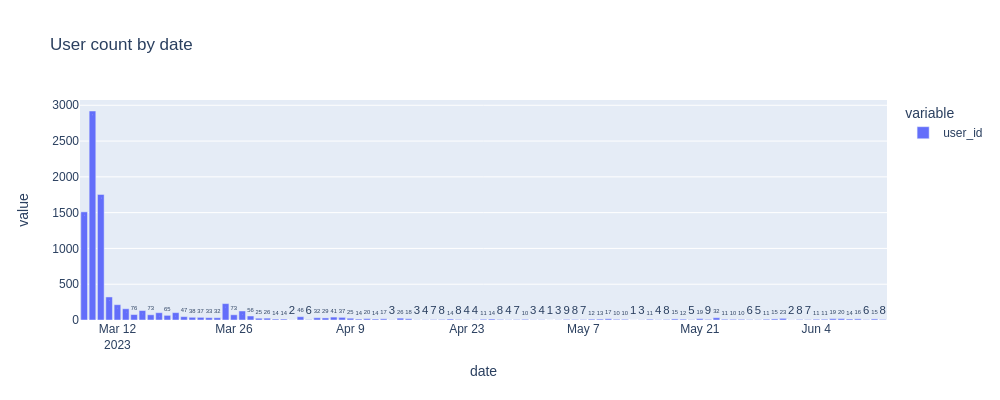

In [65]:
fig = px.bar(
    df_after_release.groupby('date')['user_id'].count(),
    text_auto=True,
    title='User count by date'
)
fig.show(renderer='png', width=1000, height=400)

### 質問回答数

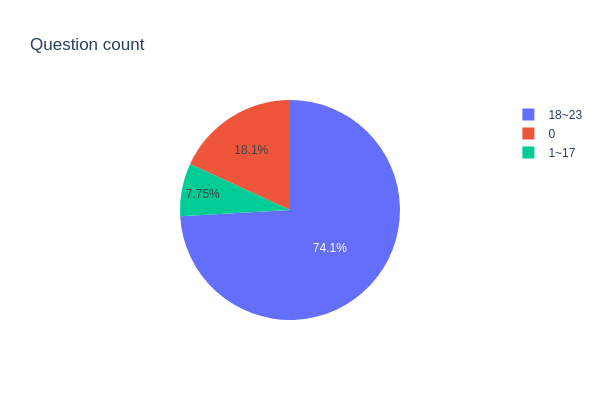

In [66]:
fig = px.pie(
    df_after_release,
    names='question_cat',
    title='Question count'
)
fig.show(renderer='png', width=600, height=400)

### ランキング
- 質問に1回以上回答したユーザー内で、ランキングの町の数
- 通常は10 (回答内容によっては10未満の場合もあり得る)
- 0は、ランキング表示まで至らなかったユーザー数

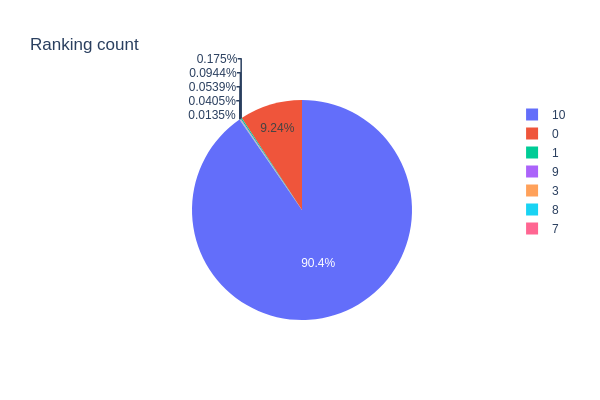

In [67]:
fig = px.pie(
    df_after_release[df_after_release['questions_count'] > 0],
    names='ranking_count',
    title='Ranking count'
)
fig.show(renderer='png', width=600, height=400)

### 町詳細画面の表示数
- ランキングを表示したユーザー内で、町詳細画面を表示した数
- 0は、ランキングだけ見て、町詳細は見なかったユーザー

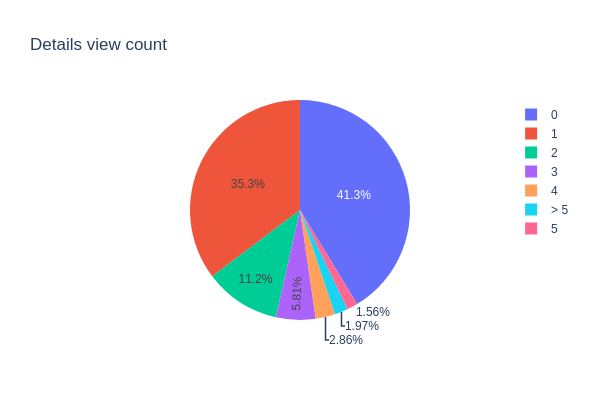

In [68]:
fig = px.pie(
    df_after_release[df_after_release['ranking_count'] > 0],
    names='details_cat',
    title='Details view count'
)
fig.show(renderer='png', width=600, height=400)

In [69]:
df_after_release['family'].value_counts()

単身      3235
夫婦子供    1966
夫婦      1741
その他      201
Name: family, dtype: int64

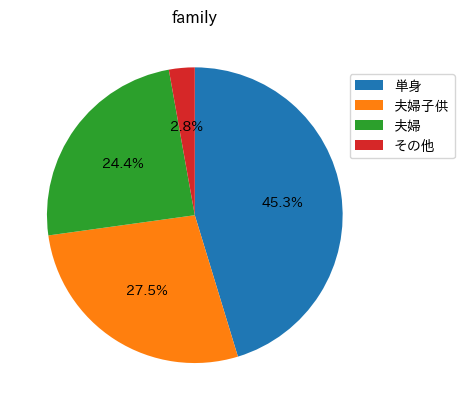

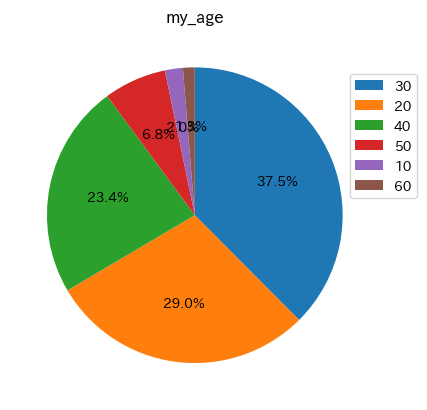

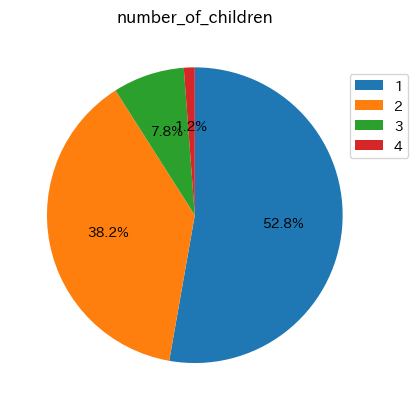

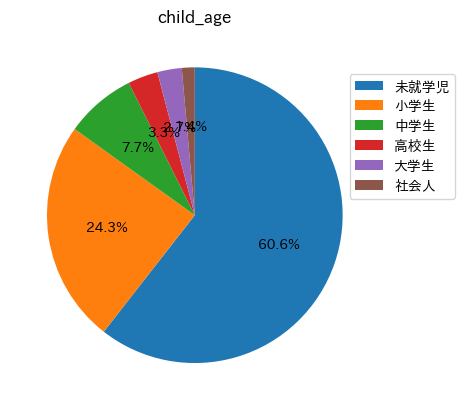

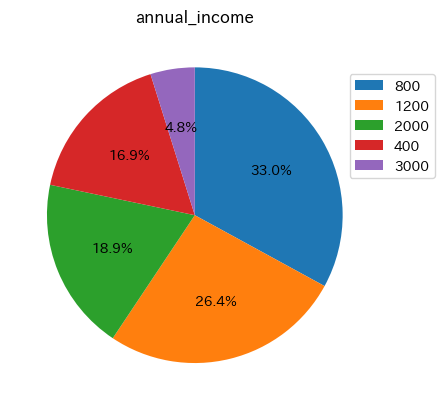

In [91]:
for question in questions:
    # fig = px.pie(
    #     df_after_release[df_after_release[question].notna()],
    #     names=question,
    #     title=question
    # )
    # fig.show(renderer='png', width=600, height=400)

    data = df_after_release[df_after_release[question].notna()][question].value_counts()
    plt.pie(
        data,
        counterclock=False,
        startangle=90,
        autopct="%1.1f%%"
    )
    plt.title(question)
    plt.legend(data.index, loc='upper left',bbox_to_anchor=(0.9,0.9))
    plt.show()